In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys
print(sys.executable)
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path, models_path
from tensorflow.keras import layers, models
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import tensorflow as tf
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import matplotlib.pyplot as plt


/home/nwertheim/Master-Thesis/thesisenv/bin/python


2025-04-02 13:43:28.427708: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 13:43:28.619191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743594208.691538  995811 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743594208.718026  995811 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743594208.853126  995811 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
data_file = os.path.join(univariate_data_path, 'merged_univariate.npy')
data = np.load(data_file, allow_pickle=True)
print(data.shape)

# Check for NaN or Inf values in signals
for sample in data:
    if np.isnan(sample['signal']).any() or np.isinf(sample['signal']).any():
        print(f"NaN or Inf detected in {sample['record_name']}")

(666,)


In [3]:
# Masking function using patch-based masking
def mask_data(x, mask_ratio=0.5, patch_size=8):
    """ Apply patch-based masking to 1D signals """
    x_masked = np.copy(x)
    num_patches = x.shape[1] // patch_size  # Number of patches
    mask = np.random.rand(num_patches) < mask_ratio  # Randomly mask patches
    for i in range(num_patches):
        if mask[i]:
            x_masked[:, i * patch_size:(i + 1) * patch_size, :] = 0  # Zero out patches
    return x_masked

# Create windows from the data
def create_windows(sequence, window_size, step_size):
    windows = [sequence[i:i+window_size] for i in range(0, len(sequence) - window_size + 1, step_size)]
    return np.array(windows)

# Set windowing parameters
window_size = 500  
step_size = 250    

# Assuming `data` is a list of dictionaries with signal data
# Apply windowing to all records
all_windows = [create_windows(record['signal'], window_size, step_size) for record in data]
all_windows = np.concatenate(all_windows, axis=0)

# Reshape for Conv1D (batch_size, time_steps, channels)
all_windows = np.expand_dims(all_windows, axis=-1)  
print(f"Processed window shape: {all_windows.shape}")

Processed window shape: (454061, 500, 1)


GPU VERSION

In [16]:
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn.functional as F

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Print the device being used

search_space = [
    Real(1e-5, 1e-2, "log-uniform", name='learning_rate'),
    Categorical([16, 32, 64], name='batch_size'),
    Integer(2, 5, name='num_layers'),
    Categorical([8, 16, 32, 64], name='base_filters'),
    Real(0.1, 0.9, "uniform", name='mask_ratio')  # Add mask_ratio to the search space
]

# Perform an 80-10-10 split
X_train, X_temp = train_test_split(all_windows, test_size=0.2, random_state=42)  # First split (80% train, 20% temp)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)  # Split temp into 10% val, 10% test

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")


# Create a function to build and train the model with hyperparameters
def build_model(learning_rate, num_layers, base_filters):
    input_shape = (500, 1)  # Shape of each time series window
    filters = [base_filters * (2**i) for i in range(num_layers)]  # Encoder: 2x growth
    filters += filters[-2::-1]  # Decoder: Mirror decreasing pattern
    
    layers = []
    
    # Encoder layers
    in_channels = 1  # Input has 1 channel
    for i in range(num_layers):
        layers.append(nn.Conv1d(in_channels, filters[i], kernel_size=3, stride=1, padding=1))
        layers.append(nn.BatchNorm1d(filters[i]))  # BatchNorm added
        layers.append(nn.ReLU())
        in_channels = filters[i]  # Update input channels for next layer
    
    # Decoder layers (reverse the filters)
    for i in range(num_layers - 2, -1, -1):  # Skip the last filter in the encoder part
        layers.append(nn.ConvTranspose1d(in_channels, filters[i], kernel_size=3, stride=1, padding=1))
        layers.append(nn.BatchNorm1d(filters[i]))  # BatchNorm added
        layers.append(nn.ReLU())
        in_channels = filters[i]
    
    # Final layer (reconstruct to the original input size)
    layers.append(nn.Conv1d(in_channels, 1, kernel_size=3, stride=1, padding=1))
    
    # Combine all layers into a single sequential model
    model = nn.Sequential(*layers).to(device)  # Move model to device
    return model


def objective(params):
    learning_rate, batch_size, num_layers, base_filters, mask_ratio = params  # Add mask_ratio as a parameter
    batch_size = int(batch_size) 
    # Compute filter sizes
    filters = [base_filters * (2**i) for i in range(num_layers)]  # Encoder: 2x growth
    filters += filters[-2::-1]  # Decoder: Mirror decreasing pattern
    
    # Print the hyperparameters and filters for each layer
    print(f"Learning Rate: {learning_rate}, Batch Size: {batch_size}, Num Layers: {num_layers}, Base Filters: {base_filters}, Mask Ratio: {mask_ratio}")
    print(f"Filters per layer: {filters}")  # Print filter sizes for each layer
    
    # Build the model
    model = build_model(learning_rate, num_layers, base_filters)
    
    # Split the data into training and validation sets
    # Use the predefined train and validation sets
    global X_train, X_val  # Ensure these stay constant outside the loop

    
    # Apply masking to the data with the specified mask_ratio
    X_train_masked = np.array([mask_data(window, mask_ratio=mask_ratio) for window in X_train])
    X_val_masked = np.array([mask_data(window, mask_ratio=mask_ratio) for window in X_val])
    
    # Convert to PyTorch tensors and move to device
    tensor_X_train = torch.tensor(X_train_masked, dtype=torch.float32).permute(0, 2, 1).to(device)  # [batch, channels, seq_len]
    tensor_X_val = torch.tensor(X_val_masked, dtype=torch.float32).permute(0, 2, 1).to(device)
    tensor_Y_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1).to(device)
    tensor_Y_val = torch.tensor(X_val, dtype=torch.float32).permute(0, 2, 1).to(device)

    # Create datasets & loaders
    train_dataset = torch.utils.data.TensorDataset(tensor_X_train, tensor_Y_train)
    val_dataset = torch.utils.data.TensorDataset(tensor_X_val, tensor_Y_val)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Set up optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    model.train()
    for epoch in range(5):  # 5 epochs for tuning
        print('Epoch', epoch)
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.mse_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = F.mse_loss(outputs, targets)
            val_loss += loss.item()
    
    # Print the validation loss to the console
    print(f"Validation Loss: {val_loss / len(val_loader)}")
    
    # Append the results to a file
    with open("FCMAE_tuning.txt", "a") as file:
        file.write(f"Learning Rate: {learning_rate}, Batch Size: {batch_size}, Num Layers: {num_layers}, Base Filters: {base_filters}, Mask Ratio: {mask_ratio}\n")
        file.write(f"Filters per layer: {filters}\n")  # Log filters for each layer
        file.write(f"Validation Loss: {val_loss / len(val_loader)}\n\n")
    
    return val_loss / len(val_loader)

# Run Bayesian Optimization
result = gp_minimize(objective, search_space, n_calls=20, random_state=42)

# Print the best hyperparameters and validation loss to the console
best_params = result.x
print(f"Best Hyperparameters: {best_params}")

with open("FCMAE_tuning.txt", "a") as file:
    file.write(f"Best Hyperparameters: {best_params}\n")


Using device: cuda
Train size: 363248, Validation size: 45406, Test size: 45407
Learning Rate: 0.002452612631133679, Batch Size: 16, Num Layers: 4, Base Filters: 32, Mask Ratio: 0.456666202282873
Filters per layer: [32, 64, 128, 256, 128, 64, 32]
Epoch 0


KeyboardInterrupt: 

Using device: cuda

Model Architecture Overview:
Layer 0: Conv1d - 1 → 32 filters
Layer 1: BatchNorm1d - 32 features
Layer 2: ReLU (Activation)
Layer 3: Conv1d - 32 → 64 filters
Layer 4: BatchNorm1d - 64 features
Layer 5: ReLU (Activation)
Layer 6: Conv1d - 64 → 128 filters
Layer 7: BatchNorm1d - 128 features
Layer 8: ReLU (Activation)
Layer 9: Conv1d - 128 → 256 filters
Layer 10: BatchNorm1d - 256 features
Layer 11: ReLU (Activation)
Layer 12: Conv1d - 256 → 512 filters
Layer 13: BatchNorm1d - 512 features
Layer 14: ReLU (Activation)
Layer 15: ConvTranspose1d
Layer 16: BatchNorm1d - 256 features
Layer 17: ReLU (Activation)
Layer 18: ConvTranspose1d
Layer 19: BatchNorm1d - 128 features
Layer 20: ReLU (Activation)
Layer 21: ConvTranspose1d
Layer 22: BatchNorm1d - 64 features
Layer 23: ReLU (Activation)
Layer 24: ConvTranspose1d
Layer 25: BatchNorm1d - 32 features
Layer 26: ReLU (Activation)
Layer 27: Conv1d - 32 → 1 filters

Epoch 1/20
Training Loss: 0.43992562042495653
Test Loss: 0.019

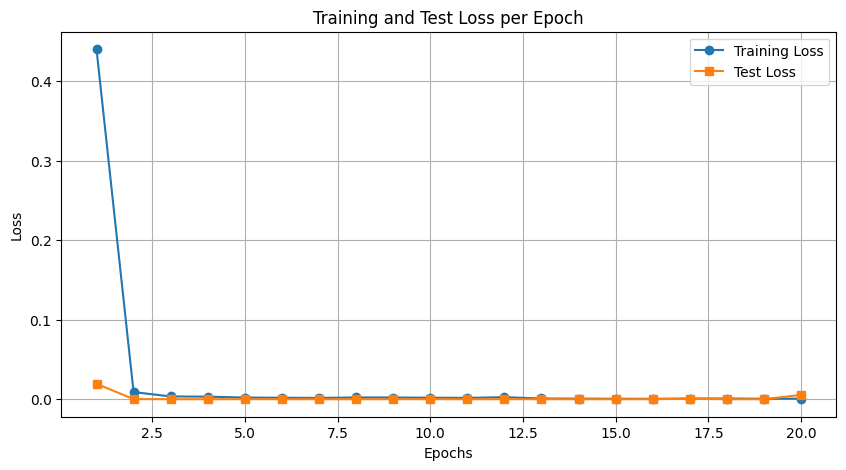

In [17]:
import os
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn  # Ensure nn is imported

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Extract the best hyperparameters from Bayesian optimization
best_learning_rate, best_batch_size, best_num_layers, best_base_filters, best_mask_ratio = (
    0.00015411065764039326, np.int64(32), np.int64(5), np.int64(32), 0.1
)
best_batch_size = int(best_batch_size)  # Ensure batch size is an integer

# Prepare data (train + validation combined, separate test set)
X_full_train = np.concatenate((X_train, X_val), axis=0)

# Apply masking to the training and test sets
X_full_train_masked = np.array([mask_data(window, mask_ratio=best_mask_ratio) for window in X_full_train])
X_test_masked = np.array([mask_data(window, mask_ratio=best_mask_ratio) for window in X_test])

# Convert to PyTorch tensors and move to device
tensor_X_train = torch.tensor(X_full_train_masked, dtype=torch.float32).permute(0, 2, 1).to(device)
tensor_X_test = torch.tensor(X_test_masked, dtype=torch.float32).permute(0, 2, 1).to(device)
tensor_Y_train = torch.tensor(X_full_train, dtype=torch.float32).permute(0, 2, 1).to(device)
tensor_Y_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1).to(device)

# Create datasets & loaders
train_dataset = TensorDataset(tensor_X_train, tensor_Y_train)
test_dataset = TensorDataset(tensor_X_test, tensor_Y_test)
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

# Build the final model
final_model = build_model(best_learning_rate, best_num_layers, best_base_filters)

# Function to print model architecture details
def print_model_summary(model):
    print("\nModel Architecture Overview:")
    print("=" * 50)
    for i, layer in enumerate(model.children()):
        if isinstance(layer, nn.Conv1d):
            print(f"Layer {i}: Conv1d - {layer.in_channels} → {layer.out_channels} filters")
        elif isinstance(layer, nn.BatchNorm1d):
            print(f"Layer {i}: BatchNorm1d - {layer.num_features} features")
        elif isinstance(layer, nn.ReLU):
            print(f"Layer {i}: ReLU (Activation)")
        elif isinstance(layer, nn.MaxPool1d):
            print(f"Layer {i}: MaxPool1d - Kernel size {layer.kernel_size}")
        elif isinstance(layer, nn.Linear):
            print(f"Layer {i}: Linear - {layer.in_features} → {layer.out_features}")
        else:
            print(f"Layer {i}: {layer.__class__.__name__}")
    print("=" * 50, "\n")

# Print the full model summary
print_model_summary(final_model)



# Define optimizer
optimizer = optim.Adam(final_model.parameters(), lr=best_learning_rate)

# Training loop with loss tracking
num_epochs = 20
train_losses = []
test_losses = []

final_model.train()
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    # Training phase
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = F.mse_loss(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Training Loss: {avg_train_loss}")

    # Validation phase (test set)
    final_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = final_model(inputs)
            loss = F.mse_loss(outputs, targets)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print(f"Test Loss: {avg_test_loss}")




# Extract the encoder layers (each Conv1d is followed by BatchNorm1d and ReLU)
encoder_layers = list(final_model.children())[:best_num_layers * 3]  # Conv1d → BatchNorm1d → ReLU blocks
encoder_model = nn.Sequential(*encoder_layers)

# Print encoder summary
print("\nEncoder Model Summary:")
print_model_summary(encoder_model)

# Save the encoder model
save_location = os.path.join(models_path, 'final_encoder_model.pth')
torch.save(encoder_model.state_dict(), save_location)
print(f"Final encoder model saved at: {save_location}")




# Save only the encoder part
# Extract the encoder layers (each Conv1d is now followed by BatchNorm1d and ReLU)
encoder_layers = list(final_model.children())[:best_num_layers * 3]  # Conv1d → BatchNorm1d → ReLU blocks
encoder_model = nn.Sequential(*encoder_layers)  # Create a new model with just the encoder


# Define save path
save_location = os.path.join(models_path, 'final_encoder_model.pth')
torch.save(encoder_model.state_dict(), save_location)
print(f"Final encoder model saved at: {save_location}")

# Plot training and test loss per epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss per Epoch")
plt.legend()
plt.grid()
plt.show()


[0.43992562042495653, 0.008997856477144005, 0.003484167455519398, 0.0032294892279926446, 0.0020921035199939794, 0.0018353436128004516, 0.0016314804892872822, 0.0022211898381526204, 0.0021571490791313106, 0.0018985870472040035, 0.0016671953294546261, 0.0025506785267808323, 0.0009145315410761728, 0.0007281899537003954, 0.0005704806676762902, 0.0005008892795496021, 0.0008746126213102184, 0.0009004993817964909, 0.0005827753442443943, 0.0007285139440527737]


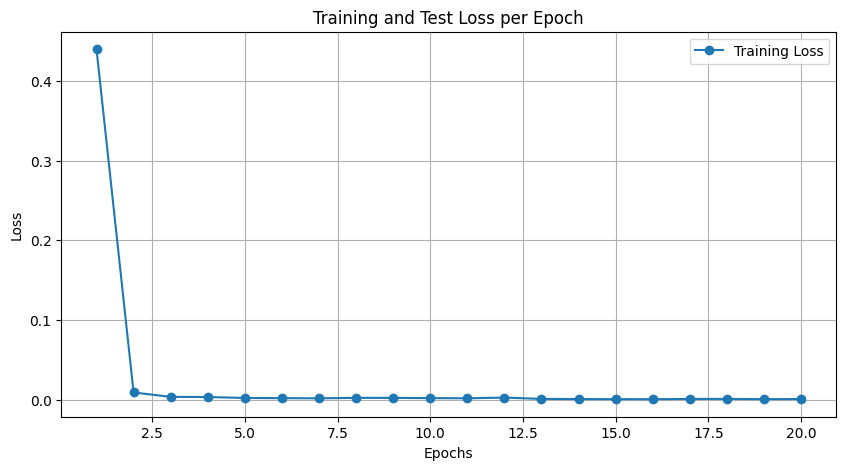

In [18]:
# Plot training and test loss per epoch
print(train_losses)
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o')
# plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss per Epoch")
plt.legend()
plt.grid()
plt.show()


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import os

class FullyConvolutionalMaskedAutoencoder(nn.Module):
    def __init__(self, input_channels=1, num_layers=2, base_filters=32):
        super().__init__()
        filters = [base_filters * (2**i) for i in range(num_layers)]
        filters += filters[-2::-1]  # Mirror decreasing pattern in decoder
        
        self.encoder = self.build_encoder(input_channels, num_layers, filters[:num_layers])
        self.decoder = self.build_decoder(input_channels, num_layers, filters[num_layers:])
    
    def build_encoder(self, input_channels, num_layers, filters):
        layers = []
        in_channels = input_channels
        for i in range(num_layers):
            layers.append(nn.Conv1d(in_channels, filters[i], kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            in_channels = filters[i]
        return nn.Sequential(*layers)
    
    def build_decoder(self, input_channels, num_layers, filters):
        layers = []
        in_channels = filters[0]
        for i in range(num_layers - 1):
            layers.append(nn.ConvTranspose1d(in_channels, filters[i + 1], kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            in_channels = filters[i + 1]
        layers.append(nn.ConvTranspose1d(in_channels, input_channels, kernel_size=3, padding=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def extract_encoder(self):
        return self.encoder  # Returns only the encoder part


def train_fcmae(model, train_data, test_data, epochs=50, batch_size=32, learning_rate=1e-4, device='cuda'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Test set evaluation
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
        
        print(f"Train Loss: {train_loss/len(train_loader)}, Test Loss: {test_loss/len(test_loader)}")
    
    return model

# Load best parameters
tuned_lr, tuned_batch_size, tuned_num_layers, tuned_base_filters, tuned_masking_ratio = (
    0.00015411065764039326, 16, 2, 32, 0.1
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare data (train + validation combined, separate test set)
X_full_train = np.concatenate((X_train, X_val), axis=0)  

# Apply masking to the training and test sets
X_full_train_masked = np.array([mask_data(window, mask_ratio=tuned_masking_ratio) for window in X_full_train])
X_test_masked = np.array([mask_data(window, mask_ratio=tuned_masking_ratio) for window in X_test])

# Convert to PyTorch tensors
tensor_X_train = torch.tensor(X_full_train_masked, dtype=torch.float32).permute(0, 2, 1)
tensor_X_test = torch.tensor(X_test_masked, dtype=torch.float32).permute(0, 2, 1)
tensor_Y_train = torch.tensor(X_full_train, dtype=torch.float32).permute(0, 2, 1)
tensor_Y_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1)

# Create datasets & loaders
train_dataset = TensorDataset(tensor_X_train, tensor_Y_train)
test_dataset = TensorDataset(tensor_X_test, tensor_Y_test)

# Train the model and track loss history
autoencoder = FullyConvolutionalMaskedAutoencoder(input_channels=1, num_layers=tuned_num_layers, base_filters=tuned_base_filters)

train_losses, test_losses = train_fcmae(
    autoencoder, train_dataset, test_dataset, 
    epochs=2, batch_size=tuned_batch_size, 
    learning_rate=tuned_lr, device=device, 
    track_loss=True  # Ensure the function tracks loss history
)

# Extract & save encoder
encoder = autoencoder.extract_encoder()
save_location = os.path.join(models_path, 'final_encoder_model.pth')
torch.save(encoder.state_dict(), save_location)
print("Final encoder model saved!")

# Plot train & test loss per epoch
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()


IndexError: list index out of range

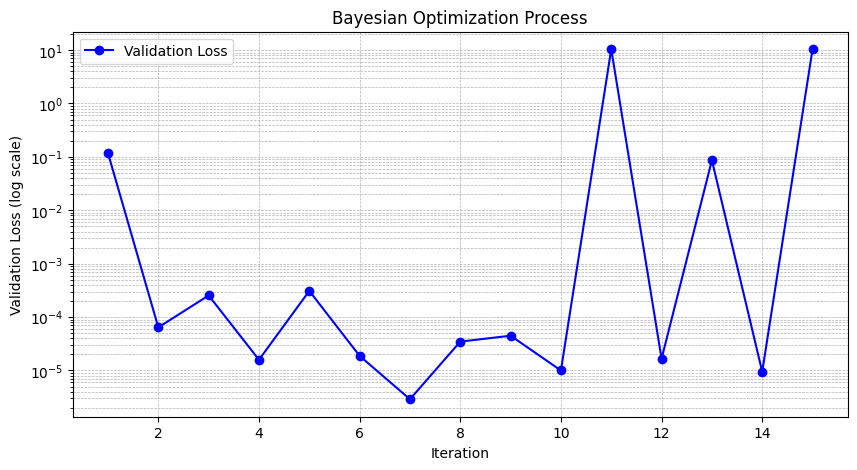

In [6]:
losses = [0.1172099539710155, 6.407403082149263e-05, 0.0002541058594707158, 1.5849841748207635e-05, 0.0003091122876550678, 1.8754082667867506e-05, 2.893403804114779e-06, 3.467623455682149e-05, 4.477721797192431e-05, 9.994277683975585e-06, 10.387348465364193, 1.6604045512285203e-05, 0.08650258629779063, 9.450406993995935e-06, 10.387575098710467]

import matplotlib.pyplot as plt
import numpy as np

# Validation losses collected during Bayesian Optimization
# losses = [
#     0.1172099539710155, 6.407403082149263e-05, 0.0002541058594707158, 1.5849841748207635e-05,
#     0.0003091122876550678, 1.8754082667867506e-05, 2.893403804114779e-06, 3.467623455682149e-05,
#     4.477721797192431e-05, 9.994277683975585e-06, 10.387348465364193, 1.6604045512285203e-05,
#     0.08650258629779063, 9.450406993995935e-06, 10.387575098710467
# ]

# Iteration numbers
iterations = np.arange(1, len(losses) + 1)

# Plot the validation loss per iteration
plt.figure(figsize=(10, 5))
plt.plot(iterations, losses, marker='o', linestyle='-', color='b', label='Validation Loss')
plt.yscale('log')  # Log scale to handle large variations in loss values
plt.xlabel('Iteration')
plt.ylabel('Validation Loss (log scale)')
plt.title('Bayesian Optimization Process')
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()